<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [412]:
import matplotlib.pyplot as plt

% matplotlib inline

UsageError: Line magic function `%` not found.


In [417]:
import pandas as pd
import numpy as np
import scipy as stats
import seaborn as sns
from sklearn.datasets import load_boston

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns= ['MEDV'])

print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [423]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)

In [424]:
df['MEDV'] = y

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [3]:
# Exploratory data analysis.

# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column


In [425]:
df.shape


(506, 14)

In [426]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [427]:
df.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

In [428]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


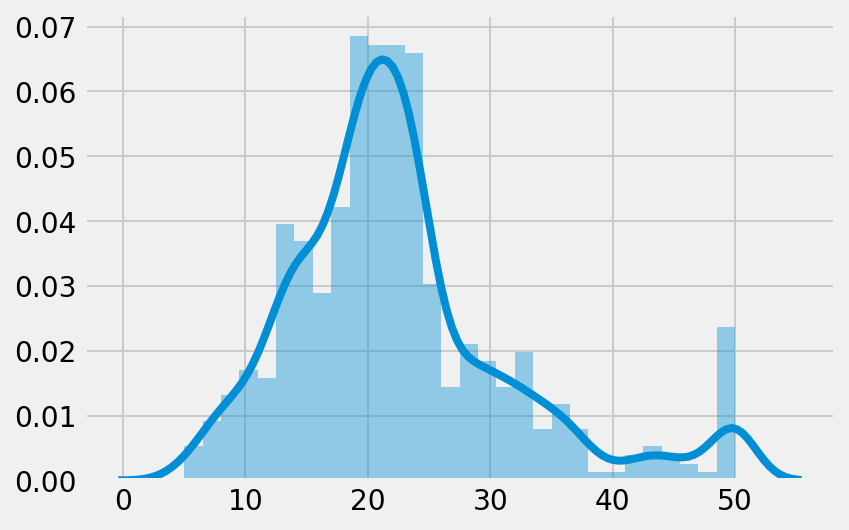

In [429]:
sns.distplot(y, bins=30)
plt.show()

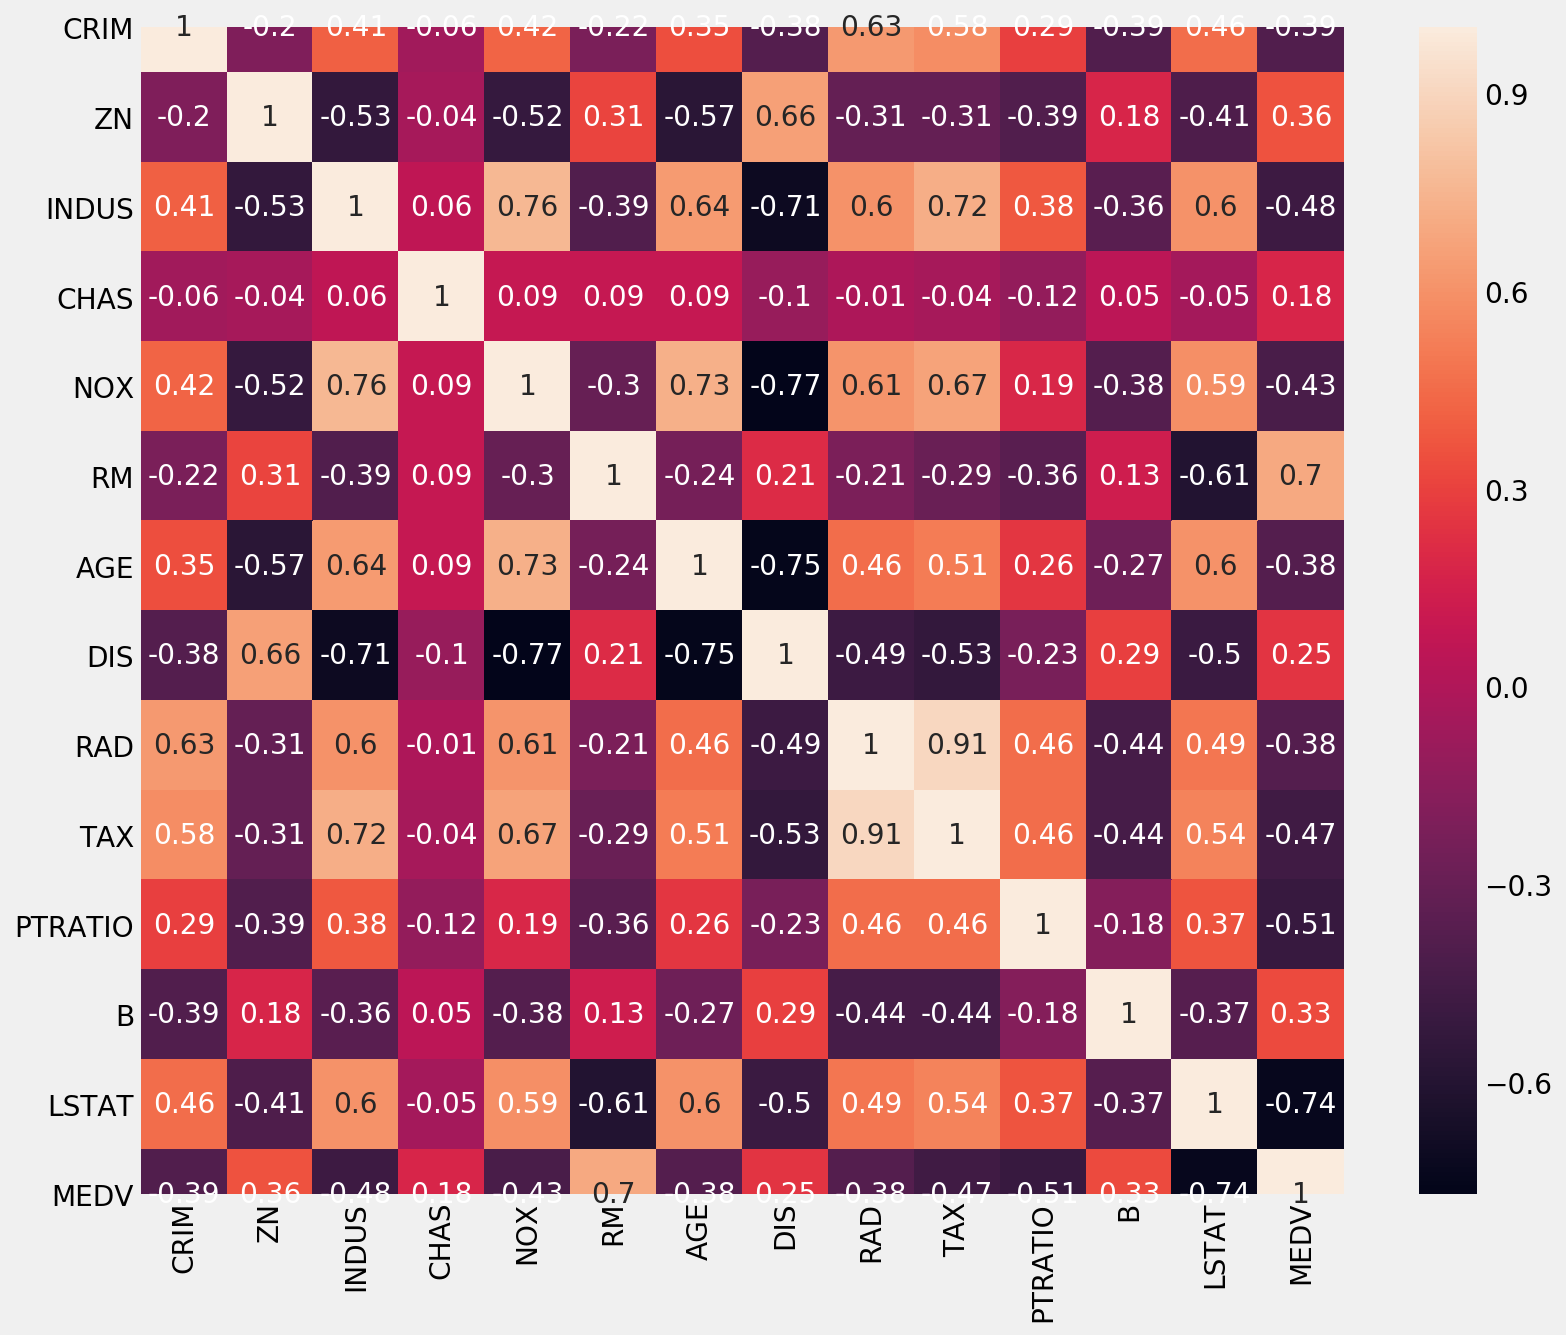

In [441]:
correlation_matrix = df.corr().round(2)
plt.figure(figsize=(12,10))
sns.heatmap(data=correlation_matrix, annot=True);

In [ ]:
#pretty clean data, nice dataset.

## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

In [361]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [362]:
linreg = LinearRegression()

linreg.fit(X, y)

# for ALL variables initially to see fit.

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [363]:
linreg.score(X, y)

0.7406426641094095

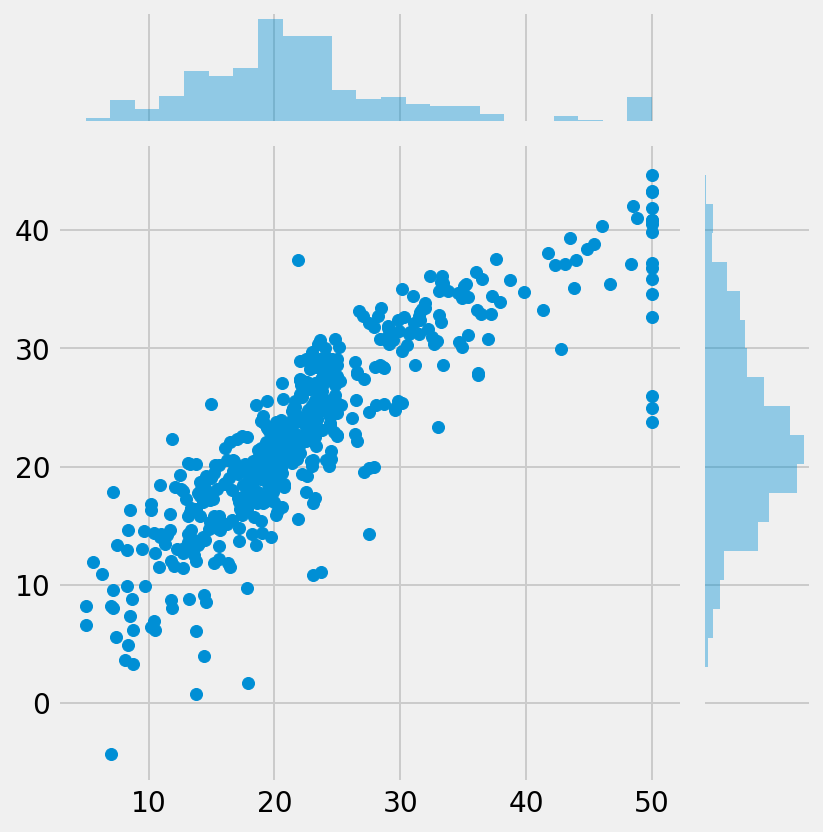

In [364]:
y_pred = linreg.predict(X)
sns.jointplot(y, y_pred)

In [431]:
# then narrowing variables to 4 chosen ones.
# CRIM, RM, AGE, DIS

X_pred = pd.DataFrame(np.c_[df['CRIM'], df['RM'], df['AGE'], df['DIS'] ])
y = df['MEDV']

In [432]:
lr1 = LinearRegression()

lr1.fit(X_pred, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [367]:
lr1.score(X_pred, y)

0.5753318198331642

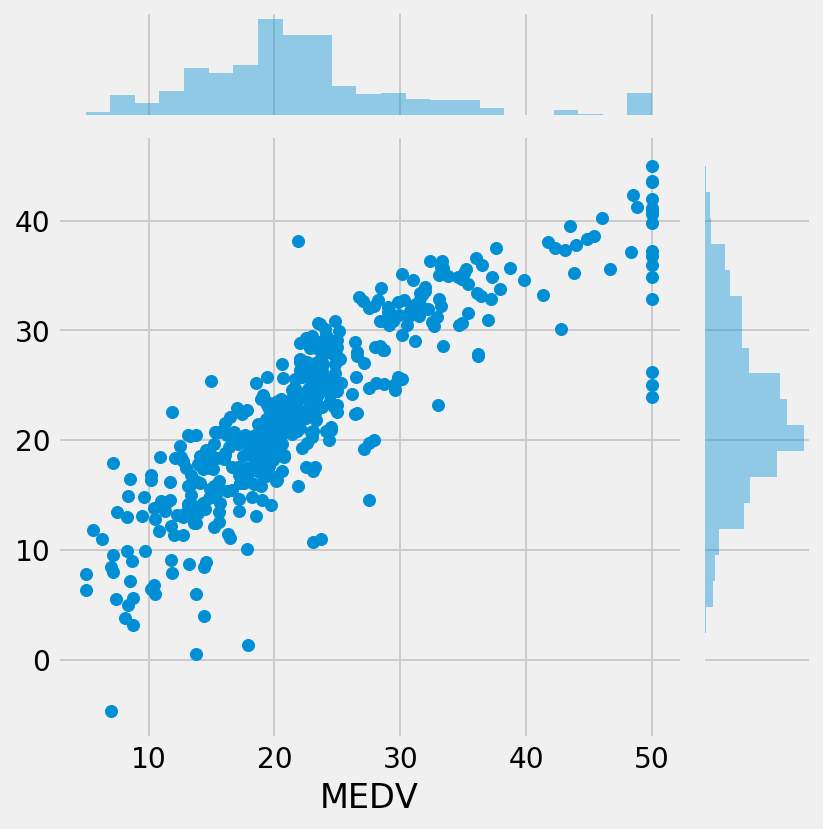

In [266]:
y_pred1 = linreg.predict(X)
sns.jointplot(y, y_pred1)

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [368]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression



X_train, X_test, y_train, y_test = train_test_split(X_pred, y, train_size=0.7, random_state=8)

linreg = LinearRegression()
linreg.fit(X_train, y_train)
linreg.score(X_test, y_test)

0.5770291529716314

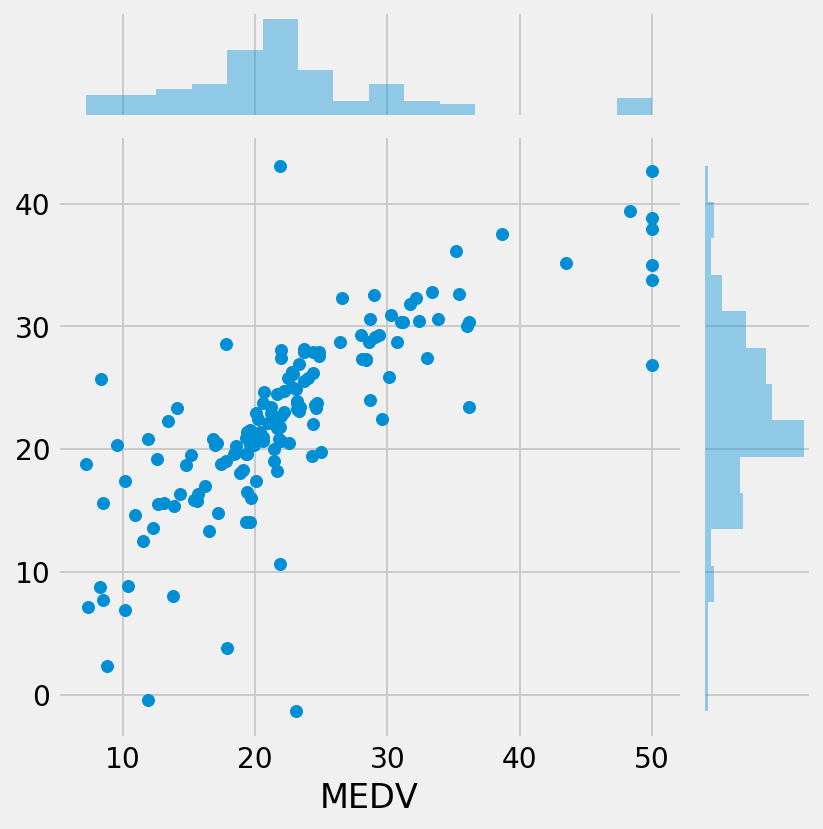

In [263]:
ypred70 = linreg.predict(X_test)
sns.jointplot(y_test, ypred70)

In [ ]:
# at 70% training, the model scores almost the same as the linear regression.

In [369]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X_pred, y, train_size=0.9, random_state=8)

linreg = LinearRegression()
linreg.fit(X_train, y_train)
linreg.score(X_test, y_test)

0.5202717718756309

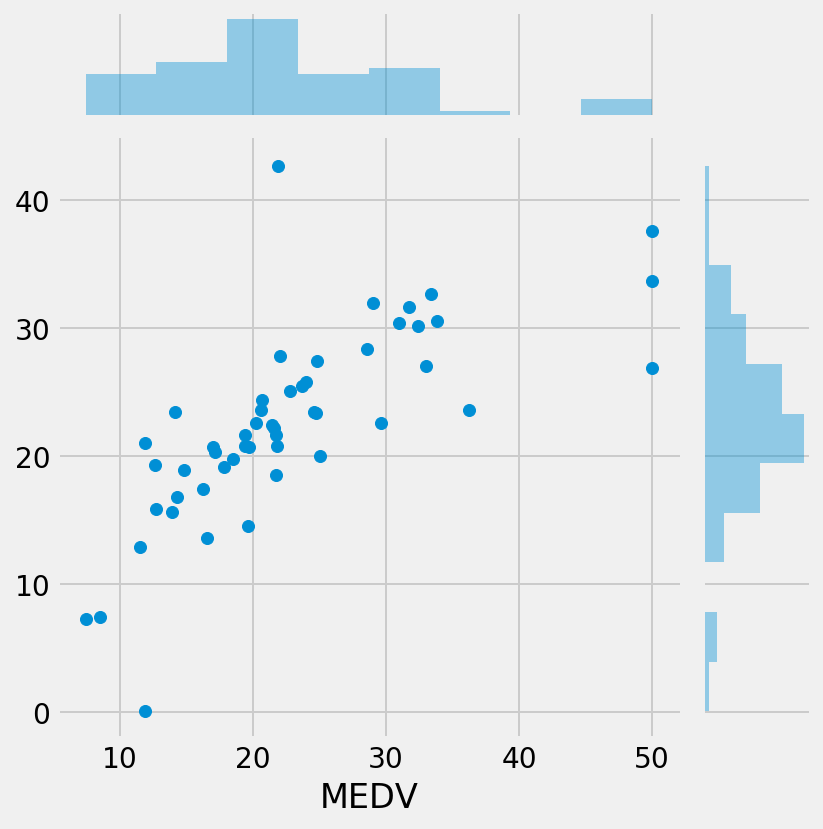

In [370]:
ypred90 = linreg.predict(X_test)
sns.jointplot(y_test, ypred90)

In [302]:
# at 90% training, the model has a fair bit lower accuracy vs the original linear regression, 
# likely as the test sample is now quite small

### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [371]:
from sklearn import model_selection
import sklearn.metrics as metrics

kf = model_selection.KFold(n_splits=10, shuffle=True)

mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X_pred, y):
    lr2 = LinearRegression().fit(X_pred.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr2.predict(X_pred.iloc[test_index])))
    scores.append(lr2.score(X_pred, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 31.99185700465201
R2: 0.5752788378239624

Model 2
MSE: 23.498705397274303
R2: 0.5748421046494758

Model 3
MSE: 55.82433950646492
R2: 0.5739282175775235

Model 4
MSE: 36.84618519652232
R2: 0.5742903254159358

Model 5
MSE: 44.47452766321696
R2: 0.5749695114228539

Model 6
MSE: 35.116181441675586
R2: 0.5747380760410752

Model 7
MSE: 24.80880108464009
R2: 0.5747496652416949

Model 8
MSE: 22.673716560938438
R2: 0.5748889104883854

Model 9
MSE: 54.59471302972431
R2: 0.5750056311228477

Model 10
MSE: 37.41829078083513
R2: 0.5749931824838042

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 36.72473176659441
Mean of R2 for all folds: 0.5747684462267558


In [ ]:
# attempting to fine-tune the model by finding optimal K

In [372]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [373]:
# Calculate TRAINING ERROR and TESTING ERROR for K=1 through 100.

X_train, X_test, y_train, y_test = train_test_split(X_pred, y, random_state=8)


k_range = list(range(1, 101))
training_error = []
testing_error = []

# Find test accuracy for all values of K between 1 and 100 (inclusive).
for k in k_range:

    # Instantiate the model with the current K value.
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Calculate training error (error = 1 - accuracy).
    y_pred_class = knn.predict(X_pred)
    training_accuracy = metrics.accuracy_score(y, y_pred1)
    training_error.append(1 - training_accuracy)
    
    # Calculate testing error.
    y_pred_class = knn.predict(X_test)
    testing_accuracy = metrics.accuracy_score(y_test, y_pred1)
    testing_error.append(1 - testing_accuracy)

ValueError: Unknown label type: 'continuous'

# KNN Practice

In [392]:
# Read the iris data into a DataFrame
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

In [393]:
iris.head()

# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

In [394]:
# Create a custom colormap
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

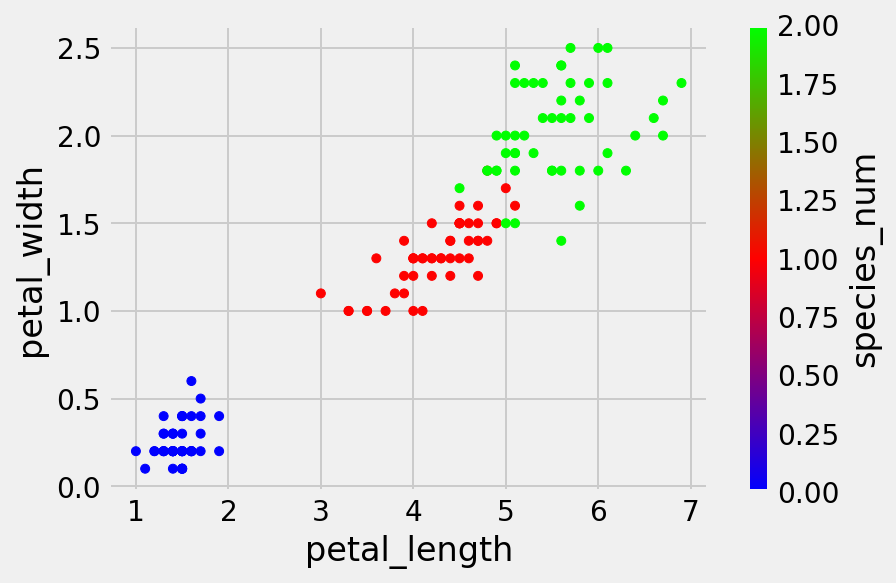

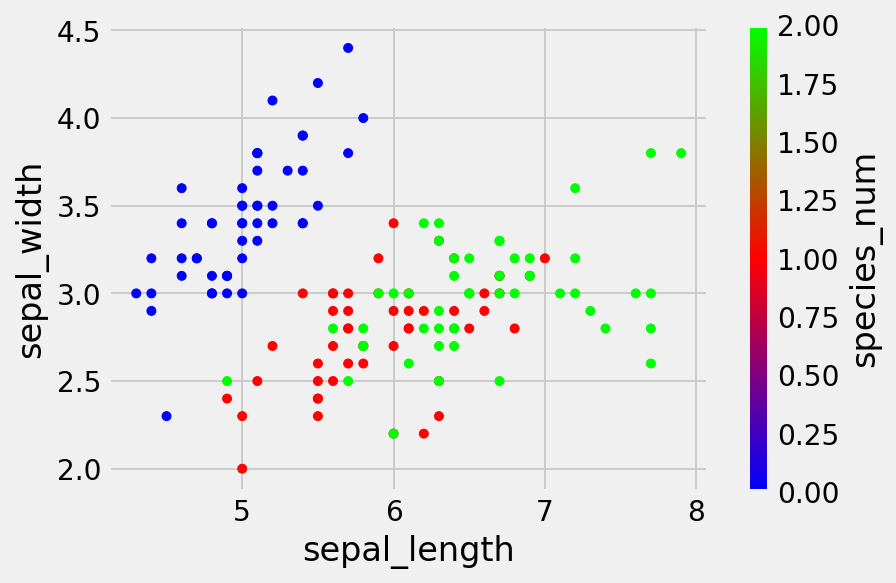

In [395]:
# Map each iris species to a number
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'

iris['species_num'] = iris.species.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})

# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES

iris.plot(kind='scatter', x='petal_length', y='petal_width', c='species_num', colormap='brg');

# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES

iris.plot(kind='scatter', x='sepal_length', y='sepal_width', c='species_num', colormap='brg');

In [396]:
iris.head()


,sepal_length,sepal_width,petal_length,petal_width,species,species_num
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0


## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [397]:
X_iris = iris.iloc[:, 0:4]

In [398]:
X_iris.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### Create your target vector "y"
This will be the species type.

In [399]:
y_iris = iris['species_num']

#using species_num as a proxy as species is a string, but we have already classified each string species into a numerical value.

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [400]:
X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris)

lr_iris = LinearRegression()
lr_iris.fit(X_train, y_train)
lr_iris.score(X_test, y_test)

0.9142470473837935

### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [401]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [402]:
y_pred_class = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.9210526315789473


### Create a Model With Five Neighbors. Did it Improve?

In [403]:
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train, y_train)

y_pred_5 = knn5.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_5))

0.9473684210526315


In [ ]:
# did improve on the model, so predicting to 5 neighbours vs 1 is was helpful in improving accuracy.

### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

In [406]:
# Calculate TRAINING ERROR and TESTING ERROR for K=1 through 100.

k_range = list(range(1, 101))
training_error = []
testing_error = []

# Find test accuracy for all values of K between 1 and 100 (inclusive).
for k in k_range:

    # Instantiate the model with the current K value.
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Calculate training error (error = 1 - accuracy).
    y_pred_class = knn.predict(X_iris)
    training_accuracy = metrics.accuracy_score(y_iris, y_pred_class)
    training_error.append(1 - training_accuracy)
    
    # Calculate testing error.
    y_pred_class = knn.predict(X_test)
    testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
    testing_error.append(1 - testing_accuracy)

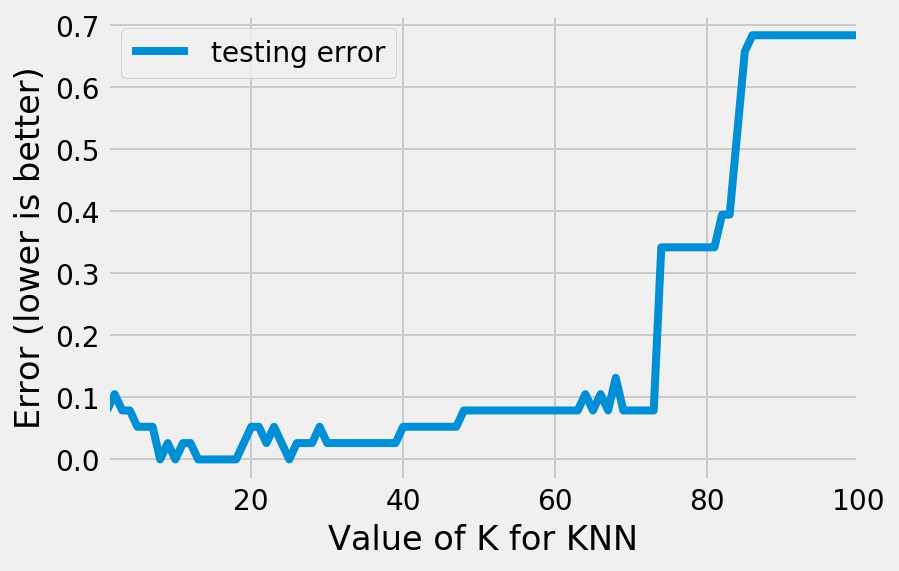

In [433]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

column_dict = {'K': k_range, 'training error':training_error, 'testing error':testing_error}
df_iris = pd.DataFrame(column_dict).set_index('K').sort_index(ascending=False)

df_iris.plot(y='testing error');
plt.xlabel('Value of K for KNN');
plt.ylabel('Error (lower is better)');

In [ ]:
# a k of around 16-18 is optimal is terms of the accuracy of the model.

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

In [ ]:
# as knn is needed to needed to predict classes and so need to predict a collection rather than a single number.
# knn.predict_proba predicts the probability of that k value being a close fit for the prediction of accuracy in the model.

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [434]:
# First, format our data in a DataFrame

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [435]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              1221.
Date:                Mon, 11 May 2020   Prob (F-statistic):                   1.38e-321
Time:                        11:40:04   Log-Likelihood:                         -1567.5
No. Observations:                 506   AIC:                                      3151.
Df Residuals:                     498   BIC:                                      3185.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             4.9729      0.224     22.195      0.000       4.533       5.413
LSTAT         -0.5606      0.048    -11.795      0.000      -0.654      -0.467
RAD            0.2128      0.070      3.050      0.002       0.076       0.350
TAX           -0.0174      0.004     -4.272      0.000      -0.025      -0.009
NOX            4.3448      3.384      1.284      0.200      -2.304      10.994
INDUS          0.0924      0.067      1.383      0.167      -0.039       0.224
CRIM          -0.0891      0.037     -2.423      0.016      -0.161      -0.017
ZN             0.0288      0.013      2.220      0.027       0.003       0.054
==============================================================================
Omnibus:                      192.139   Durbin-Watson:                   0.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              832.155
Skew:                           1.666   Prob(JB):                    1.99e-181
Kurtosis:                       8.326   Cond. No.                     6.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

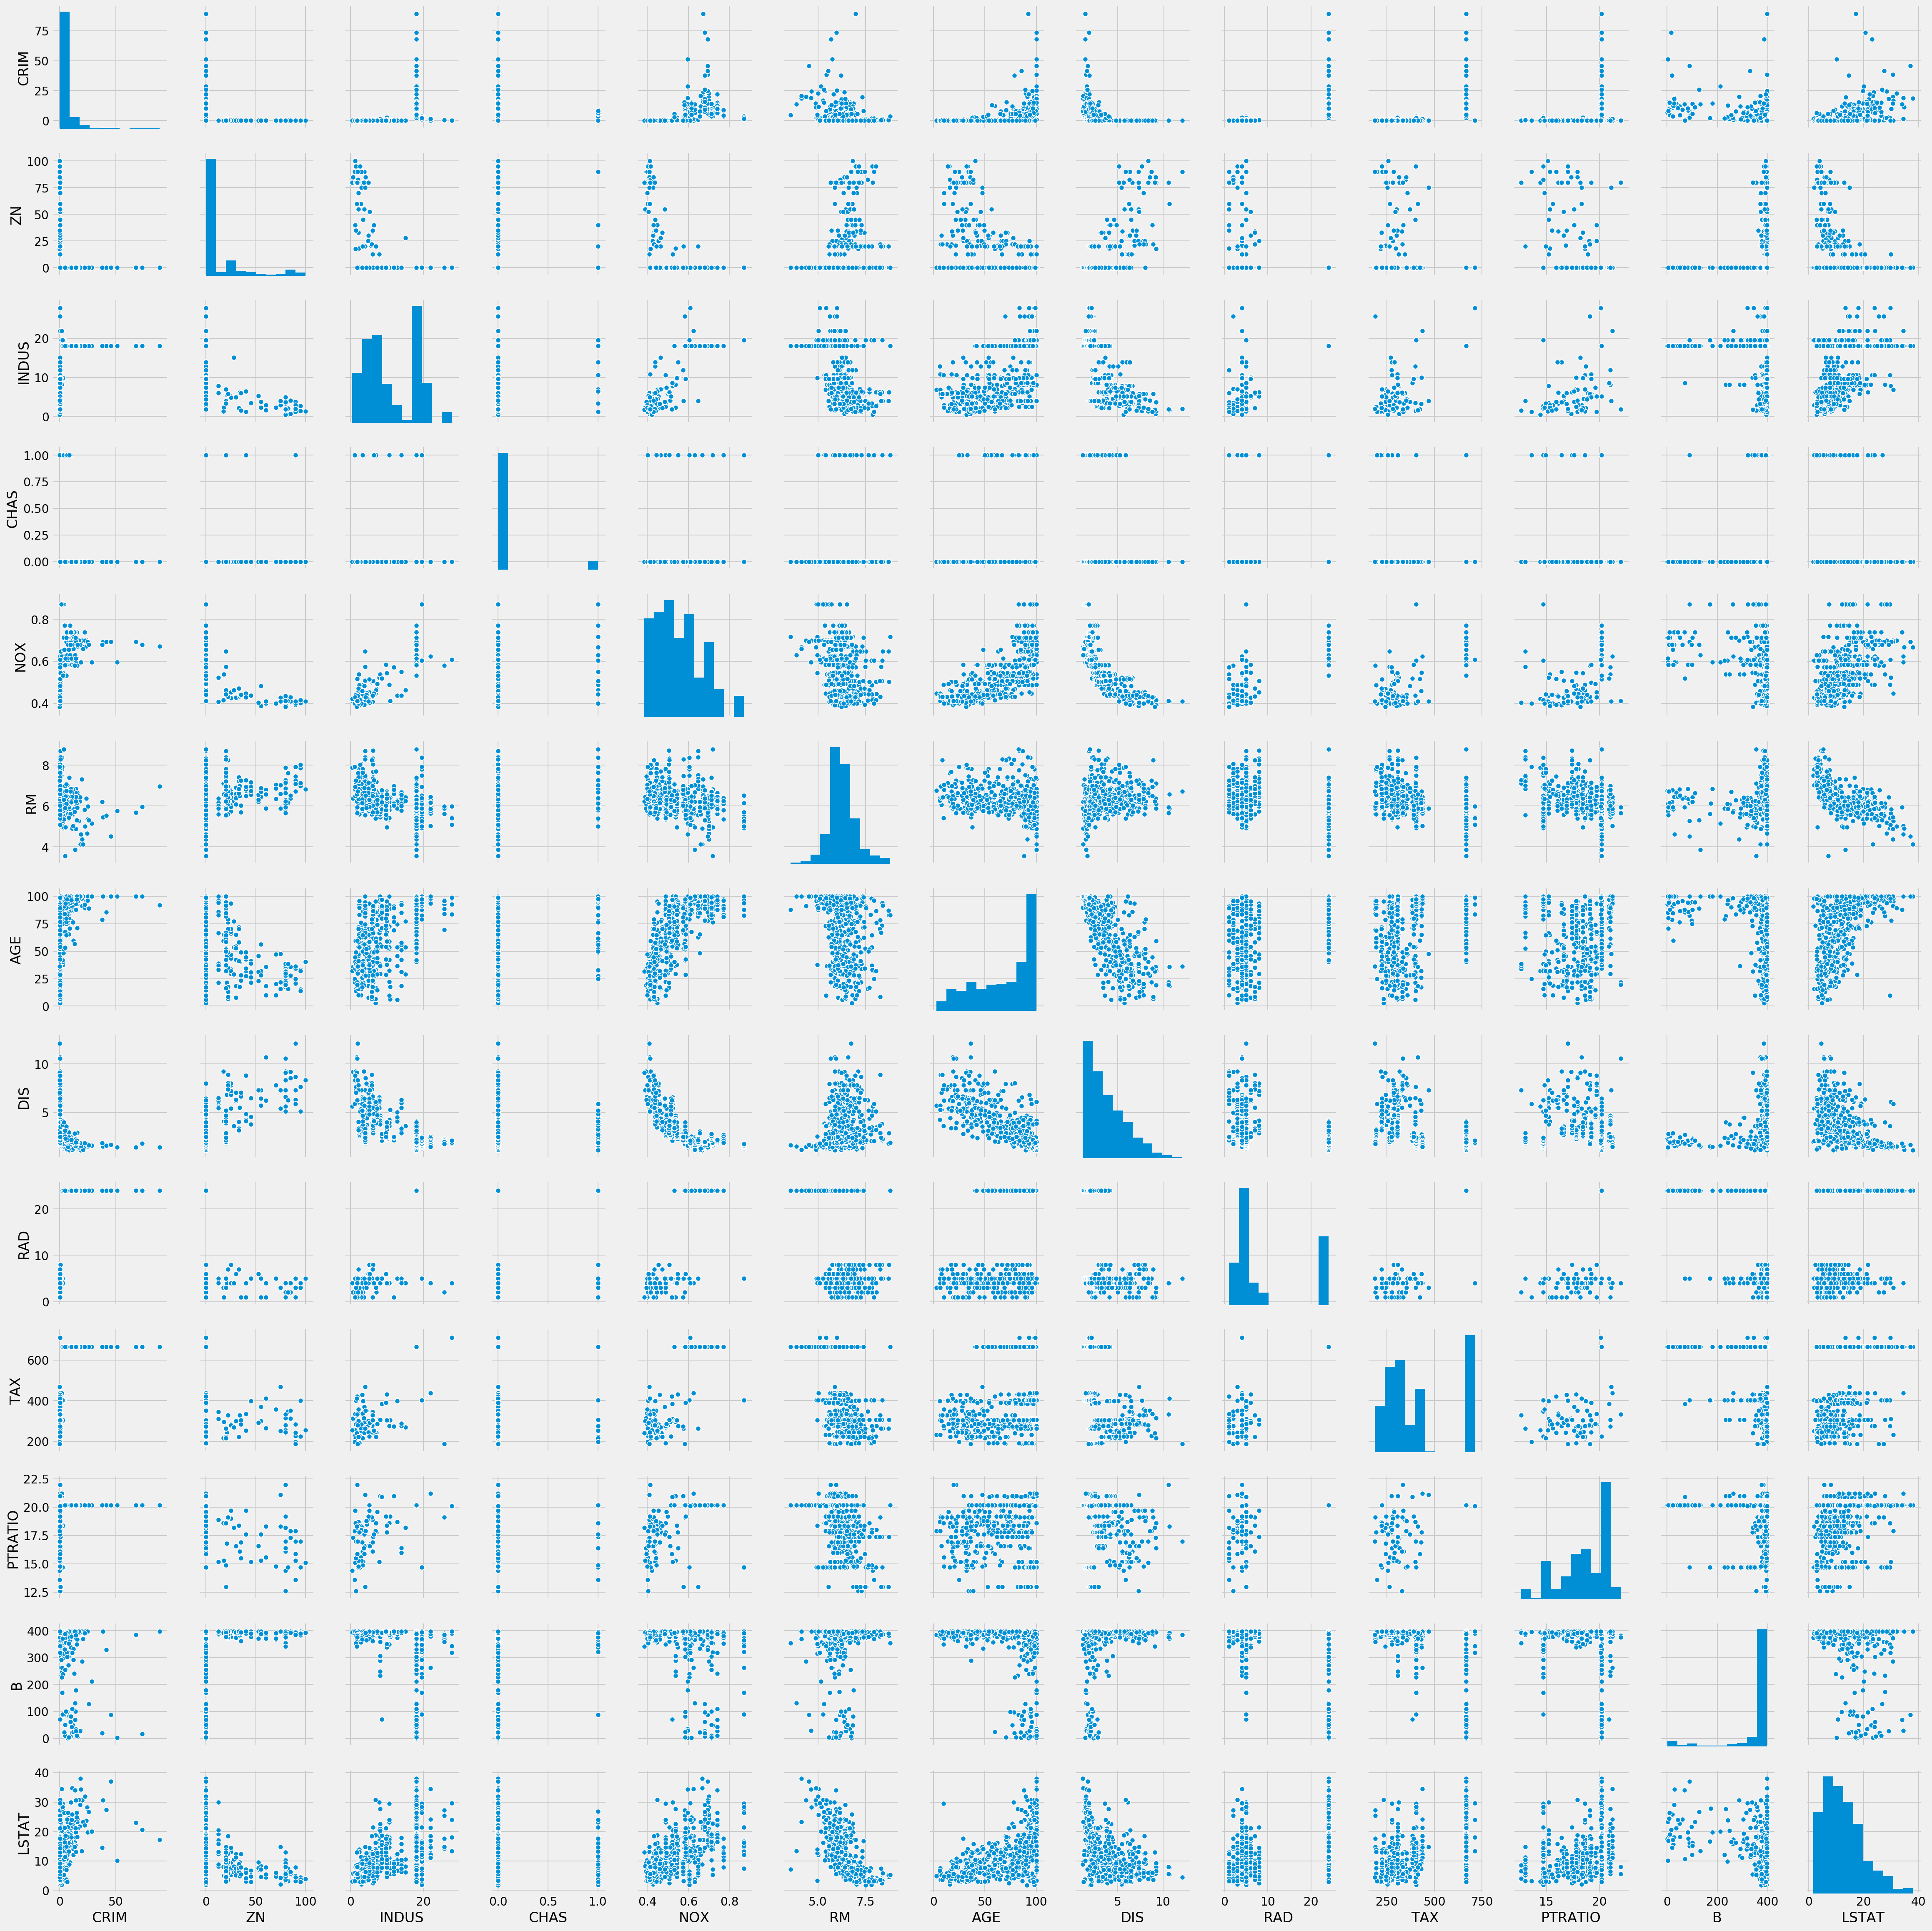

In [436]:
# Check out variable relations
import seaborn as sns

sns.pairplot(X);

In [440]:
# Check out Pearson scores
from scipy.stats.stats import pearsonr

pearsonr(X, y)

TypeError: No loop matching the specified signature and casting
was found for ufunc add

## Demo: Patsy

In [437]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [438]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


In [439]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))

R^2 Score: 0.3441966075483136
